<a href="https://colab.research.google.com/github/babupallam/Msc_AI_Module2_Natural_Language_Processing/blob/main/L03-Learning%20to%20Classify%20Text/Note_04_Deep_Learning_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- In this section, we will discuss how deep learning techniques can be applied to text classification tasks. Deep learning models are capable of automatically learning complex patterns in data, and they do not rely heavily on manual feature engineering.
- Instead, they learn hierarchical representations from the raw data, making them suitable for text classification tasks where capturing nuanced language patterns is essential.
- This section will cover the basics of neural networks, various deep learning architectures used for text classification, and practical considerations.



#### 4.1 **Introduction to Neural Networks**

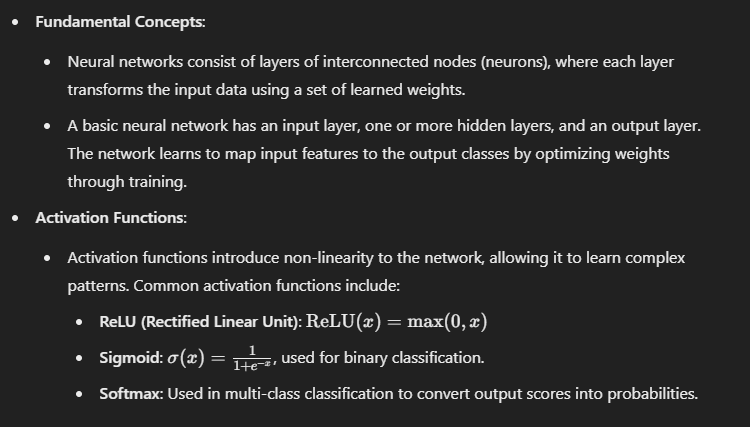

#### 4.2 **Convolutional Neural Networks (CNNs)**
- **How CNNs Work**:
  - Originally designed for image processing, CNNs are effective for text classification by treating text data as sequential information.
  - The convolutional layers apply filters (kernels) that slide over the text representation (e.g., word embeddings), detecting local patterns (e.g., n-grams) in the text.
  - **Pooling Layers**: Reduce the dimensionality of the output, retaining important features while reducing computational cost.


- **Applications in Text Classification**:
  - CNNs are effective for tasks such as sentiment analysis and topic categorization, where capturing local patterns in text is important.


- **Advantages**:
  - Automatically learn useful features and patterns from text data.
  - Can capture n-gram-like features without explicitly creating them.



##### Text Classification using Convolutional Neural Networks (CNNs)

Step 1: Preprocess the text data using NLTK and transform it into numerical features.


In [ ]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Download necessary NLTK datasets
nltk.download('movie_reviews')
nltk.download('stopwords')
from nltk.corpus import movie_reviews

# Load the movie reviews dataset
documents = [" ".join(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]
labels = [1 if category == 'pos' else 0 for category in movie_reviews.categories() for _ in movie_reviews.fileids(category)]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2, random_state=42)

# Use TF-IDF to convert the text data into numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words=nltk.corpus.stopwords.words('english'))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Step 2: Build a CNN model for text classification using PyTorch.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_sizes, num_filters, dropout):
        super(TextCNN, self).__init__()

        # Convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=ks)
            for ks in kernel_sizes
        ])

        # Fully connected layer for output
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Reshape input to [batch_size, 1, input_dim]
        x = x.unsqueeze(1)

        # Apply convolution + ReLU + MaxPooling for each kernel size
        conved = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate the pooled features
        cat = torch.cat(pooled, dim=1)

        # Apply dropout and the fully connected layer
        out = self.fc(self.dropout(cat))
        return out

# Hyperparameters
input_dim = 2000  # Number of input features (same as the number of TF-IDF features)
output_dim = 2    # Binary classification (positive or negative)
kernel_sizes = [3, 4, 5]  # Different kernel sizes for convolutional layers
num_filters = 100  # Number of filters for each convolutional layer
dropout = 0.5      # Dropout rate

# Initialize the model
model = TextCNN(input_dim, output_dim, kernel_sizes, num_filters, dropout)


Step 3: Train the CNN model.


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.7036
Epoch [2/5], Loss: 0.7003
Epoch [3/5], Loss: 0.6986
Epoch [4/5], Loss: 0.6995
Epoch [5/5], Loss: 0.7035


Step 4: Evaluate the CNN model on the test data.


In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%, Average Loss: {avg_loss:.4f}")

# Evaluate the model
evaluate_model(model, test_loader, criterion)


Test Accuracy: 55.25%, Average Loss: 0.6885


#### 4.3 **Recurrent Neural Networks (RNNs) and Variants**
- **How RNNs Work**:
  - RNNs are designed for sequential data, where each input is processed in sequence, with the hidden state carrying information from previous steps.
  - Suitable for tasks where context and order matter, such as language modeling and named entity recognition.
- **Challenges with RNNs**:
  - Suffer from the "vanishing gradient problem," where long-term dependencies are hard to capture due to gradients becoming too small during backpropagation.
- **LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit)**:
  - LSTMs and GRUs address the limitations of standard RNNs by introducing gating mechanisms that regulate the flow of information.
  - **LSTM**: Uses forget, input, and output gates to maintain long-term dependencies.
  - **GRU**: A simplified version of LSTM, with fewer gates, making it computationally less expensive.
- **Use Cases**:
  - Suitable for tasks such as text generation, sequence classification, and sentiment analysis, where sequential context is important.



##### Text Classification using Basic Recurrent Neural Networks (RNNs)

###### Benchmark 1

Step 1: Preprocess the text data using NLTK and transform it into sequences.


In [ ]:
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import movie_reviews
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn.functional as F

# Download necessary NLTK datasets
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the movie reviews dataset
documents = [" ".join(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]
labels = [1 if category == 'pos' else 0 for category in movie_reviews.categories() for _ in movie_reviews.fileids(category)]

# Tokenize and preprocess the text data
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic tokens
    return tokens

documents = [preprocess_text(doc) for doc in documents]

# Create a vocabulary and encode words as integers
word_to_index = {}
for doc in documents:
    for word in doc:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index) + 1  # Start indexing from 1

# Encode the documents as sequences of integers
encoded_docs = [[word_to_index[word] for word in doc] for doc in documents]

# Pad the sequences to make them of equal length
def pad_sequences(sequences, max_len):
    return [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

max_len = 100  # Maximum sequence length
padded_docs = pad_sequences(encoded_docs, max_len)

# Convert data to PyTorch tensors
X = torch.tensor(padded_docs, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.long)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Step 2: Build an RNN-based model for text classification using PyTorch.


In [ ]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(RNNClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Recurrent layer (Simple RNN)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)

        # Pass embedded input through RNN
        output, hidden = self.rnn(embedded)

        # Use the last hidden state as the feature for classification
        last_hidden = hidden[-1]

        # Pass the last hidden state through the fully connected layer
        out = self.fc(last_hidden)
        return out

# Hyperparameters
vocab_size = len(word_to_index) + 1  # Include padding index
embedding_dim = 100  # Size of word embeddings
hidden_dim = 128  # Number of hidden units in the RNN
output_dim = 2    # Binary classification
num_layers = 2    # Number of RNN layers
dropout = 0.5     # Dropout rate for regularization

# Initialize the RNN model
rnn_model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)


Step 3: Train the RNN model.


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Train the model
train_model(rnn_model, train_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.7132
Epoch [2/5], Loss: 0.6621
Epoch [3/5], Loss: 0.5962
Epoch [4/5], Loss: 0.4839
Epoch [5/5], Loss: 0.3586


Step 4: Evaluate the RNN model on the test data.


In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%, Average Loss: {avg_loss:.4f}")

# Evaluate the model
evaluate_model(rnn_model, test_loader, criterion)


Test Accuracy: 53.00%, Average Loss: 1.1560


###### Benchmark 2

Further testing is provided

Step 5: Hyperparameter Tuning


In [ ]:
# Hyperparameter tuning example: trying different hidden dimensions and dropout rates
tuned_hidden_dim = 256  # Increased hidden dimension size
tuned_dropout = 0.3     # Reduced dropout rate

# Update the model with new hyperparameters
tuned_rnn_model = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=tuned_hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=tuned_dropout
)

# Use the same loss function and optimizer with adjusted learning rate
tuned_optimizer = optim.Adam(tuned_rnn_model.parameters(), lr=0.0005)

# Retrain the model with the new hyperparameters
train_model(tuned_rnn_model, train_loader, criterion, tuned_optimizer, num_epochs=5)

# Evaluate the tuned model on the test data
evaluate_model(tuned_rnn_model, test_loader, criterion)


Epoch [1/5], Loss: 0.7118
Epoch [2/5], Loss: 0.6453
Epoch [3/5], Loss: 0.5918
Epoch [4/5], Loss: 0.4876
Epoch [5/5], Loss: 0.3982
Test Accuracy: 48.25%, Average Loss: 1.1447


Step 6: Visualizing the Training Progress


Epoch [1/10], Loss: 0.2382
Epoch [2/10], Loss: 0.1340
Epoch [3/10], Loss: 0.0699
Epoch [4/10], Loss: 0.0279
Epoch [5/10], Loss: 0.0149
Epoch [6/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0101
Epoch [9/10], Loss: 0.0043
Epoch [10/10], Loss: 0.0044


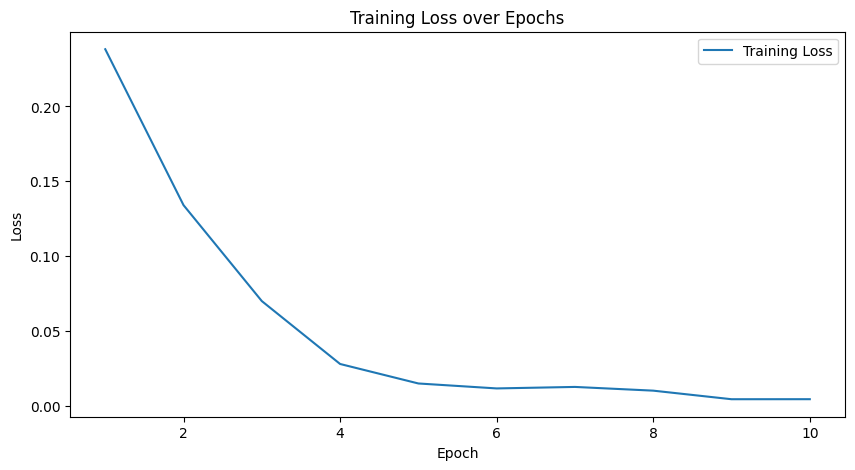

In [ ]:
import matplotlib.pyplot as plt

# Modified training function to record loss values for each epoch
def train_model_with_tracking(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return train_losses

# Train the model and track the loss values
train_losses = train_model_with_tracking(rnn_model, train_loader, criterion, optimizer, num_epochs=10)

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


Step 7: Performing Error Analysis


In [ ]:
def error_analysis(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    misclassified = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            # Forward pass
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            # Compare predictions to actual labels
            for i in range(len(y_batch)):
                if predicted[i] != y_batch[i]:
                    # Store the original review text, true label, and predicted label
                    misclassified.append((X_test[i].tolist(), y_batch[i].item(), predicted[i].item()))

    print(f"Number of Misclassified Instances: {len(misclassified)}")

    # Display a few examples of misclassified instances
    print("\nExamples of Misclassified Reviews:")
    for i, (review, true_label, predicted_label) in enumerate(misclassified[:5]):
        # Decode the review using the word_to_index dictionary
        decoded_review = " ".join([list(word_to_index.keys())[list(word_to_index.values()).index(idx)] for idx in review if idx != 0])
        print(f"Review: {decoded_review}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        print("-" * 80)

# Perform error analysis on the RNN model
error_analysis(rnn_model, test_loader)


Number of Misclassified Instances: 187

Examples of Misclassified Reviews:
Review: felix sami bouajila siege lives contented life boyfriend daniel pierre loup rajot little town dieppe northern france laid job discovering address father abandoned born decides journey marseilles south find man never met adventures felix writers directors olivier ducastel jacques martineau made debut musical comedy jeanne perfect guy embracing typically american genre second effort adventures felix borrows america tale young man hits road find felix happy life dieppe ferry company works falls prey economics chunnel job loose ends goes late mother papers learns father never knew living marseilles hundreds miles away felix makes snap decision journey south puts together supply cocktails
True Label: 1, Predicted Label: 0
--------------------------------------------------------------------------------
Review: synopsis maniac crazed virulent microphage slaughters twenty people including street gang heavily arm

###### Benchmark 3

Step 8: Text Classification Using LSTM for Improved Performance


In [ ]:
# Updated RNN model to use LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)

        # Pass embedded input through LSTM
        output, (hidden, cell) = self.lstm(embedded)

        # Use the last hidden state for classification
        last_hidden = hidden[-1]

        # Pass the last hidden state through the fully connected layer
        out = self.fc(last_hidden)
        return out

# Initialize the LSTM model
lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)

# Train and evaluate the LSTM model
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
train_model(lstm_model, train_loader, criterion, lstm_optimizer, num_epochs=5)
evaluate_model(lstm_model, test_loader, criterion)


Epoch [1/5], Loss: 0.6925
Epoch [2/5], Loss: 0.6577
Epoch [3/5], Loss: 0.5396
Epoch [4/5], Loss: 0.3621
Epoch [5/5], Loss: 0.1457
Test Accuracy: 52.00%, Average Loss: 1.7803


###### Benchmark 4

Step 10: Text Classification Using GRU (Gated Recurrent Unit)


In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layer
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)

        # Pass embedded input through GRU
        output, hidden = self.gru(embedded)

        # Use the last hidden state for classification
        last_hidden = hidden[-1]

        # Pass the last hidden state through the fully connected layer
        out = self.fc(last_hidden)
        return out

# Initialize the GRU model
gru_model = GRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)

# Train and evaluate the GRU model
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
train_model(gru_model, train_loader, criterion, gru_optimizer, num_epochs=5)
evaluate_model(gru_model, test_loader, criterion)


Epoch [1/5], Loss: 0.6972
Epoch [2/5], Loss: 0.6492
Epoch [3/5], Loss: 0.5533
Epoch [4/5], Loss: 0.3858
Epoch [5/5], Loss: 0.1896
Test Accuracy: 52.75%, Average Loss: 1.4586


Step 11: Applying Regularization Techniques to Prevent Overfitting


In [ ]:
# Reinitialize the LSTM model with higher dropout rate for regularization
lstm_regularized_model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=0.6  # Increase dropout rate to reduce overfitting
)

# Use L2 regularization in the optimizer
regularized_optimizer = optim.Adam(lstm_regularized_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train and evaluate the model with increased regularization
train_model(lstm_regularized_model, train_loader, criterion, regularized_optimizer, num_epochs=5)
evaluate_model(lstm_regularized_model, test_loader, criterion)


Epoch [1/5], Loss: 0.6935
Epoch [2/5], Loss: 0.6724
Epoch [3/5], Loss: 0.5847
Epoch [4/5], Loss: 0.4167
Epoch [5/5], Loss: 0.2213
Test Accuracy: 50.75%, Average Loss: 1.3093


Step 12: Saving and Loading the Model


In [ ]:
# Save the trained model
torch.save(lstm_model.state_dict(), "lstm_model.pth")

# Load the model (example)
loaded_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
loaded_model.load_state_dict(torch.load("lstm_model.pth"))
loaded_model.eval()  # Set the model to evaluation mode


<ipython-input-21-a4de27bb2f26>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("lstm_model.pth"))


LSTMClassifier(
  (embedding): Embedding(38734, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

###### Benchmark 5

Step 13: Text classification using Bidirectional RNNs

Bidirectional RNNs (including Bidirectional LSTM and GRU) process the input data in both forward and backward directions, which helps the model capture context from both sides of a word sequence.



In [ ]:
class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BidirectionalLSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply hidden_dim by 2 for bidirectional

    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)

        # Pass embedded input through the bidirectional LSTM
        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate the last hidden state from both directions
        last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Pass the concatenated hidden states through the fully connected layer
        out = self.fc(last_hidden)
        return out

# Initialize the bidirectional LSTM model
bidirectional_lstm_model = BidirectionalLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Train and evaluate the bidirectional LSTM model
bidirectional_optimizer = optim.Adam(bidirectional_lstm_model.parameters(), lr=0.001)
train_model(bidirectional_lstm_model, train_loader, criterion, bidirectional_optimizer, num_epochs=5)
evaluate_model(bidirectional_lstm_model, test_loader, criterion)


Epoch [1/5], Loss: 0.6933
Epoch [2/5], Loss: 0.6190
Epoch [3/5], Loss: 0.4180
Epoch [4/5], Loss: 0.1718
Epoch [5/5], Loss: 0.0645
Test Accuracy: 57.25%, Average Loss: 1.7422


Step 14: Using Learning Rate Scheduling


In [ ]:
# Use a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(bidirectional_optimizer, step_size=3, gamma=0.1)

# Modified training function to include learning rate scheduling
def train_model_with_scheduler(model, train_loader, criterion, optimizer, scheduler, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.5f}")

# Train the model using the scheduler
train_model_with_scheduler(bidirectional_lstm_model, train_loader, criterion, bidirectional_optimizer, scheduler, num_epochs=5)


Epoch [1/5], Loss: 0.0109, Learning Rate: 0.00100
Epoch [2/5], Loss: 0.0036, Learning Rate: 0.00100
Epoch [3/5], Loss: 0.0027, Learning Rate: 0.00010
Epoch [4/5], Loss: 0.0021, Learning Rate: 0.00010
Epoch [5/5], Loss: 0.0010, Learning Rate: 0.00010


Step 15: Applying Early Stopping


In [ ]:
# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True

# Modified training function to include early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate validation loss for early stopping check
        val_loss = 0.0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_outputs = model(X_val)
                v_loss = criterion(val_outputs, y_val)
                val_loss += v_loss.item()
        val_loss /= len(val_loader)
        model.train()  # Switch back to training mode

        # Print loss and check for early stopping
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Train the model with early stopping
train_model_with_early_stopping(bidirectional_lstm_model, train_loader, test_loader, criterion, bidirectional_optimizer, num_epochs=20, patience=3)


Epoch [1/20], Training Loss: 0.0008, Validation Loss: 2.4492
Epoch [2/20], Training Loss: 0.0008, Validation Loss: 2.4793
Epoch [3/20], Training Loss: 0.0006, Validation Loss: 2.5027
Epoch [4/20], Training Loss: 0.0006, Validation Loss: 2.5179
Early stopping triggered.


Step 16: Advanced Evaluation Methods


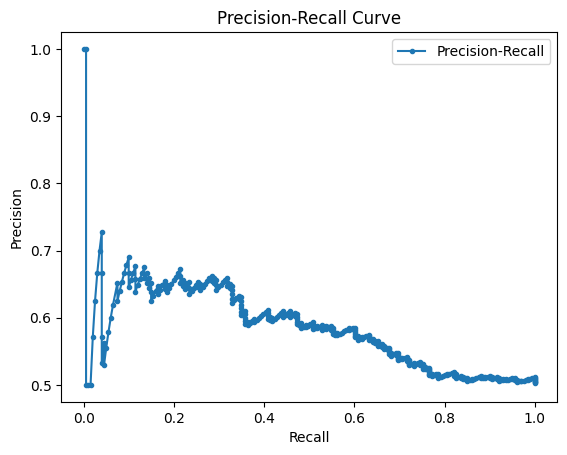

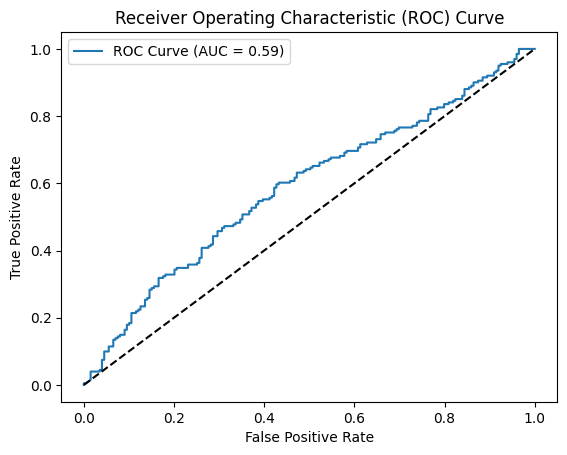

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, marker='.', label='Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Get model predictions and probabilities
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = bidirectional_lstm_model(X_batch)
        probs = F.softmax(outputs, dim=1)[:, 1]
        y_scores.extend(probs.numpy())
        y_true.extend(y_batch.numpy())

# Plot Precision-Recall and ROC curves
plot_precision_recall_curve(y_true, y_scores)
plot_roc_curve(y_true, y_scores)


###### Benchmark 6

To compare the four RNN models implemented earlier (Simple RNN, LSTM, GRU, and Bidirectional LSTM) for text classification, we will:
  - Train each model on the same dataset.
  - Evaluate their performance using common metrics such as accuracy, loss, precision, recall, and F1-score.
  - Compare the models' training times and their ability to generalize on the test set.

Step 1: Define the Training and Evaluation Workflow


In [ ]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to train the model and record the training time
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    start_time = time.time()

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

    # Calculate the training time
    training_time = time.time() - start_time

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            # Forward pass
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            # Collect the true and predicted labels
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    # Return the evaluation metrics and training time
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time
    }


Step 2: Initialize and Train Each Model


In [ ]:
# Common hyperparameters for all models
embedding_dim = 100
hidden_dim = 128
output_dim = 2
num_layers = 2
dropout = 0.5

# Initialize the models
simple_rnn_model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
gru_model = GRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
bidirectional_lstm_model = BidirectionalLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)

# Optimizers for each model
rnn_optimizer = optim.Adam(simple_rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
bidirectional_optimizer = optim.Adam(bidirectional_lstm_model.parameters(), lr=0.001)

# Criterion
criterion = nn.CrossEntropyLoss()


Step 3: Train and Evaluate Each Model


In [ ]:
# Number of epochs for training
num_epochs = 5

# Train and evaluate the Simple RNN model
print("Training Simple RNN...")
rnn_metrics = train_and_evaluate_model(simple_rnn_model, train_loader, test_loader, criterion, rnn_optimizer, num_epochs)
print(f"Simple RNN Metrics: {rnn_metrics}")

# Train and evaluate the LSTM model
print("\nTraining LSTM...")
lstm_metrics = train_and_evaluate_model(lstm_model, train_loader, test_loader, criterion, lstm_optimizer, num_epochs)
print(f"LSTM Metrics: {lstm_metrics}")

# Train and evaluate the GRU model
print("\nTraining GRU...")
gru_metrics = train_and_evaluate_model(gru_model, train_loader, test_loader, criterion, gru_optimizer, num_epochs)
print(f"GRU Metrics: {gru_metrics}")

# Train and evaluate the Bidirectional LSTM model
print("\nTraining Bidirectional LSTM...")
bidirectional_lstm_metrics = train_and_evaluate_model(bidirectional_lstm_model, train_loader, test_loader, criterion, bidirectional_optimizer, num_epochs)
print(f"Bidirectional LSTM Metrics: {bidirectional_lstm_metrics}")


Training Simple RNN...
Epoch [1/5], Loss: 0.7147
Epoch [2/5], Loss: 0.6580
Epoch [3/5], Loss: 0.6016
Epoch [4/5], Loss: 0.5109
Epoch [5/5], Loss: 0.3675
Simple RNN Metrics: {'accuracy': 0.49, 'precision': 0.49246231155778897, 'recall': 0.48756218905472637, 'f1_score': 0.49, 'training_time': 28.77508783340454}

Training LSTM...
Epoch [1/5], Loss: 0.6946
Epoch [2/5], Loss: 0.6587
Epoch [3/5], Loss: 0.5468
Epoch [4/5], Loss: 0.3392
Epoch [5/5], Loss: 0.1296
LSTM Metrics: {'accuracy': 0.505, 'precision': 0.5088757396449705, 'recall': 0.42786069651741293, 'f1_score': 0.4648648648648649, 'training_time': 49.590044260025024}

Training GRU...
Epoch [1/5], Loss: 0.6977
Epoch [2/5], Loss: 0.6559
Epoch [3/5], Loss: 0.5660
Epoch [4/5], Loss: 0.4008
Epoch [5/5], Loss: 0.2066
GRU Metrics: {'accuracy': 0.5175, 'precision': 0.5210526315789473, 'recall': 0.4925373134328358, 'f1_score': 0.5063938618925832, 'training_time': 59.54173016548157}

Training Bidirectional LSTM...
Epoch [1/5], Loss: 0.6945
Epoc

Step 4: Compare the Results


In [ ]:
import pandas as pd

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Simple RNN', 'LSTM', 'GRU', 'Bidirectional LSTM'],
    'Accuracy': [rnn_metrics['accuracy'], lstm_metrics['accuracy'], gru_metrics['accuracy'], bidirectional_lstm_metrics['accuracy']],
    'Precision': [rnn_metrics['precision'], lstm_metrics['precision'], gru_metrics['precision'], bidirectional_lstm_metrics['precision']],
    'Recall': [rnn_metrics['recall'], lstm_metrics['recall'], gru_metrics['recall'], bidirectional_lstm_metrics['recall']],
    'F1-Score': [rnn_metrics['f1_score'], lstm_metrics['f1_score'], gru_metrics['f1_score'], bidirectional_lstm_metrics['f1_score']],
    'Training Time (s)': [rnn_metrics['training_time'], lstm_metrics['training_time'], gru_metrics['training_time'], bidirectional_lstm_metrics['training_time']]
})

# Display the comparison results
print("\nModel Comparison Results:")
print(results)



Model Comparison Results:
                Model  Accuracy  Precision    Recall  F1-Score  \
0          Simple RNN    0.4900   0.492462  0.487562  0.490000   
1                LSTM    0.5050   0.508876  0.427861  0.464865   
2                 GRU    0.5175   0.521053  0.492537  0.506394   
3  Bidirectional LSTM    0.5525   0.566265  0.467662  0.512262   

   Training Time (s)  
0          28.775088  
1          49.590044  
2          59.541730  
3          99.748509  


Step 5: Plotting the Results for Visualization


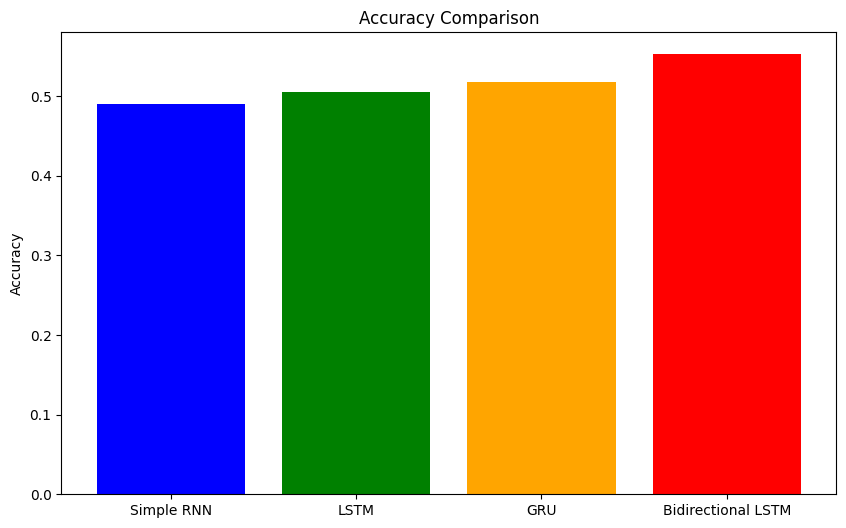

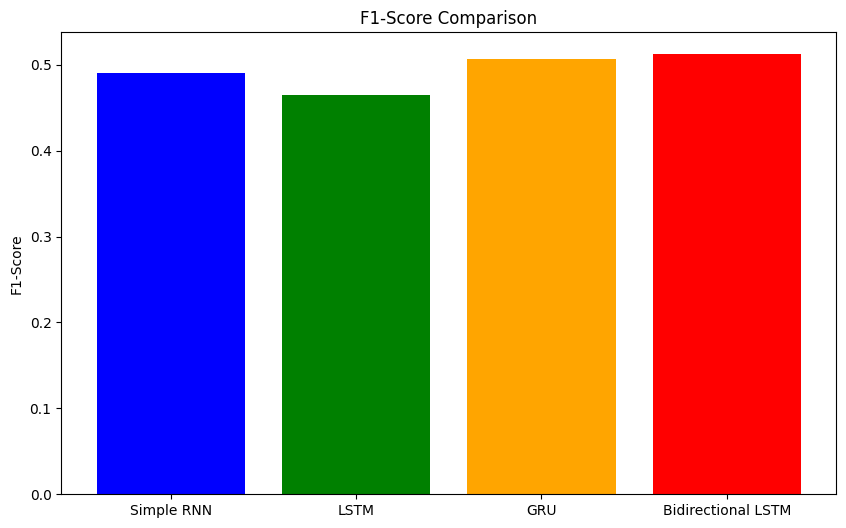

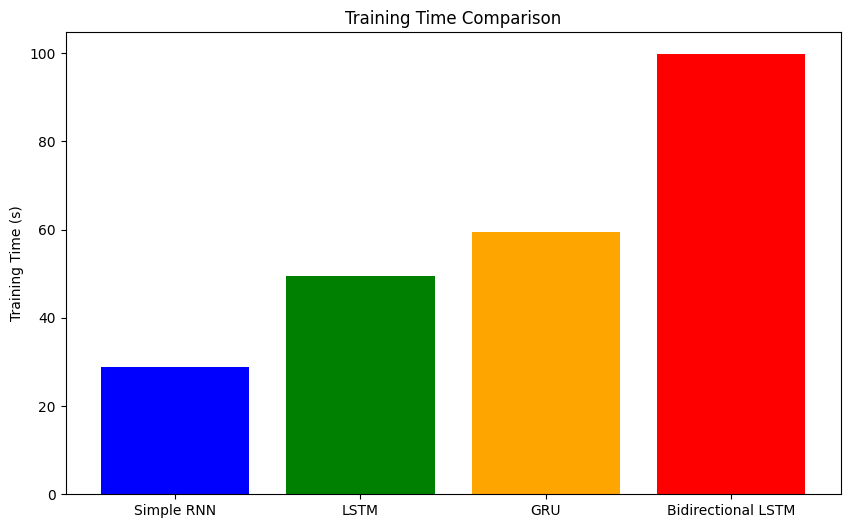

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Accuracy'], color=['blue', 'green', 'orange', 'red'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# Plot F1-Score comparison
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['F1-Score'], color=['blue', 'green', 'orange', 'red'])
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.show()

# Plot training time comparison
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Training Time (s)'], color=['blue', 'green', 'orange', 'red'])
plt.title('Training Time Comparison')
plt.ylabel('Training Time (s)')
plt.show()


#### 4.4 **Transformer Models for Text Classification**
- **Introduction to Transformers**:
  - Transformers use an attention mechanism to process input sequences in parallel, rather than sequentially, allowing them to capture long-range dependencies efficiently.
- **Self-Attention Mechanism**:
  - Each word in the sequence attends to all other words, assigning different weights based on their relevance, thus enabling the model to capture contextual relationships.
- **BERT (Bidirectional Encoder Representations from Transformers)**:
  - BERT is a pre-trained transformer model that learns contextual representations from both left and right contexts.
  - Fine-tuning BERT for text classification involves adapting the pre-trained model to a specific task (e.g., sentiment analysis, topic categorization) by adding a classification layer on top.
- **Advantages of Transformers**:
  - Can capture long-range dependencies and contextual relationships.
  - Pre-trained models can be fine-tuned for various NLP tasks with minimal labeled data.



#### 4.5 **Practical Considerations in Deep Learning for Text Classification**
- **Preprocessing**:
  - Deep learning models typically require word embeddings (e.g., Word2Vec, GloVe) or pre-trained transformer embeddings (e.g., BERT) as input.
  - Text needs to be tokenized, and sequences may be padded or truncated to a fixed length for batch processing.
- **Handling Imbalanced Data**:
  - Use techniques such as oversampling, undersampling, weighted loss functions, or data augmentation to address class imbalance.
- **Regularization Techniques**:
  - Techniques like dropout and L2 regularization can help prevent overfitting in deep learning models.
- **Hyperparameter Tuning**:
  - Tuning parameters such as learning rate, batch size, number of layers, and hidden units can significantly impact model performance.



#### 4.6 **Evaluation Metrics for Deep Learning Models**
- **Common Metrics**:
  - **Accuracy**: The proportion of correct predictions to the total predictions.
  - **Precision and Recall**: Important for imbalanced datasets to measure the quality of positive class predictions.
  - **F1-score**: The harmonic mean of precision and recall.
- **Confusion Matrix Analysis**:
  - Helps visualize the distribution of true positives, false positives, true negatives, and false negatives across different classes.
- **ROC-AUC and Precision-Recall Curves**:
  - Useful for evaluating models in binary classification tasks, especially when dealing with imbalanced datasets.



#### 4.7 **Challenges in Using Deep Learning for Text Classification**
- **Computational Requirements**:
  - Deep learning models require significant computational resources for training, especially for large datasets or pre-trained models like BERT.
- **Hyperparameter Sensitivity**:
  - Deep learning models are sensitive to hyperparameter settings, requiring extensive tuning to achieve optimal performance.
- **Overfitting**:
  - Due to the large number of parameters, deep learning models are prone to overfitting, particularly when training data is limited.



#### 4.8 **Advantages and Limitations of Deep Learning Models**
- **Advantages**:
  - Capable of learning complex patterns and representations from raw text data.
  - Do not require manual feature engineering, as features are learned automatically.
  - State-of-the-art performance on various NLP tasks, including text classification.
- **Limitations**:
  - Computationally intensive and require more resources than traditional models.
  - Longer training times, especially for large datasets or complex architectures like transformers.
  - May require large amounts of labeled data to achieve optimal performance.



#### 4.9 **Future Trends in Deep Learning for Text Classification**
- **Pre-trained Language Models and Transfer Learning**:
  - Leveraging large-scale pre-trained models (e.g., GPT, T5) and fine-tuning them for specific tasks continues to be a dominant trend.
- **Few-shot and Zero-shot Learning**:
  - Techniques that enable models to generalize to new tasks with minimal or no labeled data are gaining popularity.
- **Hybrid Models**:
  - Combining deep learning with traditional machine learning techniques for enhanced performance in certain tasks (e.g., combining BERT embeddings with SVM).



#### 4.10 **Transition to the Next Section**
- This section has provided a comprehensive overview of deep learning approaches for text classification, covering various architectures, practical considerations, and evaluation metrics.
- In the next section, we will move to **Transfer Learning and Fine-tuning**, where we will discuss how pre-trained models like BERT can be adapted to specific text classification tasks. The deep learning concepts discussed here lay the groundwork for understanding how transfer learning can further improve model performance in text classification tasks.